In [1]:
%cd /home/teresakim/fungiclef-2024/

/home/teresakim/fungiclef-2024


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pyspark.sql.functions as f
import pyspark.ml as ml
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, FloatType, IntegerType
import fungiclef.embedding.transforms as trans
from fungiclef.utils import get_spark

In [4]:
spark = get_spark(**{
    "spark.sql.parquet.enableVectorizedReader": False, 
})
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/21 18:25:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/21 18:25:41 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [5]:
gcs_parquet_path = "gs://dsgt-clef-fungiclef-2024/data/parquet/"

# define the embedding path here
#------------resnet embedding (original)
# input_folder = f"DF20_300px_resnet18" # 295,938 total
# embedding_name = "ResNet"

# ------------resnet embedding (300px) # TBD
# input_folder = f"DF20_300px_resnet18_embedding"
# embedding_name = "ResNet_300px"

# ------------dino embedding (300px combined)
input_folder = "DF20_300px_and_DF21_300px_train_embedding/dino_dct/data" # 236,769
embedding_name = "DINO"

# ------------clip embedding # TBD
# embedding_name = "CLIP"

embedding_df = spark.read.parquet(gcs_parquet_path+input_folder)
embedding_df.printSchema()
embedding_df.count()

root
 |-- ImageUniqueID: string (nullable = true)
 |-- species: string (nullable = true)
 |-- dct_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)



236769

### option 1

In [6]:
# option 1: sampling by top 5 species

# count the occurrences of each species and order by the count descending
species_counts = embedding_df.groupBy("species").count().orderBy(col("count").desc())

# get the top 5 species
top_species = species_counts.limit(5).select("species").rdd.flatMap(lambda x: x).collect()

In [7]:
# define a sample fraction, example: 10%
sample_fraction = 1.0

# filter the original df to include only records from the top 5 species and sample from them
sampled_df = embedding_df.filter(col("species").isin(top_species)).sampleBy("species", fractions={x: sample_fraction for x in top_species})

sampled_df.show()

+-----------------+-------------------+--------------------+
|    ImageUniqueID|            species|       dct_embedding|
+-----------------+-------------------+--------------------+
|2964224387-369495|Fomitopsis pinicola|[-6017.289, 11189...|
| 2608811868-57343|Fomitopsis pinicola|[-32744.195, -255...|
| 2430666183-48273|Fomitopsis pinicola|[-15580.885, 1469...|
|2382323347-340537|Fomitopsis pinicola|[-4818.051, 31154...|
|2238153750-156224|Fomitopsis pinicola|[-30071.58, -1630...|
|2901946512-368324|Fomitopsis pinicola|[-10505.926, 2119...|
|2592379635-205317|Fomitopsis pinicola|[-10245.171, 4615...|
|2238506820-172138|Fomitopsis pinicola|[-5834.8115, 1832...|
|2332528171-264602|Fomitopsis pinicola|[-13055.632, 2658...|
|2986398372-371152|Fomitopsis pinicola|[-20458.547, 2104...|
|2458346779-125444|Trametes versicolor|[-15913.026, 1499...|
|2413148999-118166|Trametes versicolor|[-23838.229, 1978...|
|2984627330-220889|Trametes versicolor|[-8464.221, 13068...|
|2542591101-275916|Trame

In [8]:
import pacmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/teresakim/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [9]:
from sklearn.preprocessing import StandardScaler

# Convert to Pandas DF
# pandas_df = sampled_df.select(["embeddings", "species"]).toPandas() # resnet
pandas_df = sampled_df.select(["dct_embedding", "species"]).toPandas() # dino

# Extract features and labels
# emb_df = np.stack(pandas_df["embeddings"].values) # resnet
emb_df = np.stack(pandas_df["dct_embedding"].values) # dino
scaled_emb = StandardScaler().fit_transform(emb_df)
labels = pandas_df["species"].tolist()

# PACMAP reduction
reducer = pacmap.PaCMAP(n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0) 
embedding = reducer.fit_transform(scaled_emb, init="pca") 

In [10]:
def plot_cluster(pandas_df, embeddings, algorithm_name):
    # Plot the data
    fig, ax = plt.subplots(figsize=(6.8, 4.2), dpi=200)
    fig.suptitle(
        f"{algorithm_name} projection of top 5 fungi species ({embedding_name})",
        fontsize=14,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["species"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["species"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species,
            s=3,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    fig.savefig(f"notebooks/evaluation/visuals/{embedding_name}_{algorithm_name}.png")
    plt.show()

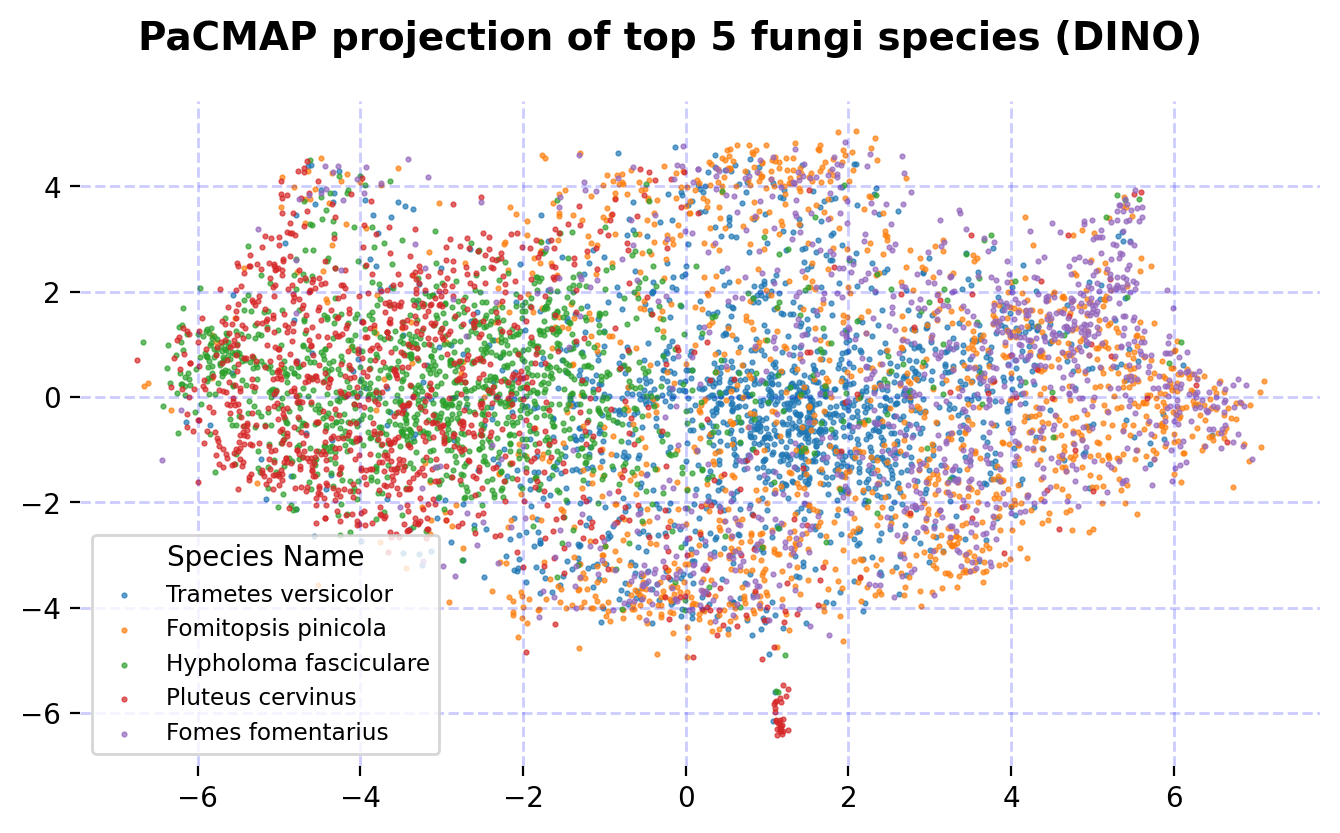

In [11]:
plot_cluster(pandas_df, embedding, algorithm_name="PaCMAP")


In [13]:
spark.stop()

### option 2